In [1]:
include("inference/mcmc/sepsis_types.jl")
using .SepsisTypes
include("inference/mcmc/sepsis.jl")
using .Sepsis
include("inference/mcmc/inference.jl")
using .Inference
include("inference/mcmc/softmax.jl")
using .Softmax
include("inference/mcmc/smart.jl")
using .Smart
include("inference/mcmc/value_iter.jl")
using .ValueIteration
using Revise
using PyCall;
using Gen;
using CairoMakie
sepsis_gym = pyimport("custom_sepsis");
np = pyimport("numpy");
using BenchmarkTools
using Serialization

In [2]:
pms = smart_functions.get_parameters()

Dict{Tuple, Vector{Float64}}()

In [3]:
function callback(state, action)
    next = get_next_state(pms, to_state(state), to_action(action), smart_functions)
    s = sepsis_gym.State(Int(next.hr), Int(next.bp), Int(next.o2), Int(next.glu), next.diabetic, next.abx, next.vaso, next.vent)
    return sepsis_gym.state_to_index[s]
end

callback (generic function with 1 method)

In [4]:
env = sepsis_gym.SepsisEnv(callback)
env.step(0)

(792, 0, false, false, Dict{Any, Any}("action" => (true, true, true), "previous" => (0, 1, 0, 1, false, false, false, false), "next_state" => (0, 0, 0, 2, false, true, true, true), "step_count" => 1))

In [13]:
training = sepsis_gym.train_dqn(env, 100000, "Test call from Julia")

PyObject <custom_sepsis.evaluate.train.Training object at 0x3464acd30>

In [14]:
training.evaluate_policy(50000)

-0.47658

In [5]:
policy, V = optimize(pms, smart_functions) 


(Dict{State, Action}(State(LOW, HIGH, LOW, LOW, true, true, true, true) => Action(true, true, true), State(HIGH, LOW, LOW, SUPER_HIGH, false, true, true, true) => Action(true, true, true), State(HIGH, HIGH, LOW, LOW, true, false, true, true) => Action(true, true, true), State(HIGH, LOW, LOW, NORMAL, false, false, false, true) => Action(true, false, true), State(HIGH, NORMAL, NORMAL, SUPER_LOW, false, false, false, true) => Action(true, true, true), State(LOW, LOW, NORMAL, LOW, false, false, true, false) => Action(true, true, true), State(LOW, NORMAL, NORMAL, SUPER_HIGH, true, true, true, false) => Action(true, false, true), State(LOW, NORMAL, NORMAL, SUPER_HIGH, false, true, false, true) => Action(true, false, true), State(LOW, LOW, LOW, NORMAL, true, false, true, true) => Action(true, false, true), State(LOW, LOW, LOW, SUPER_HIGH, false, false, false, false) => Action(true, true, true)…), [12.562170852973038; 12.562170852973038; … ; 9.351531444819253; 9.351531444819253;;;])

In [6]:
pol = to_gym_pol(policy);

In [7]:
sepsis_gym.evaluate_policy(pol, 50000)

-0.30986

# MCMC on History

In [3]:
choices = choicemap()
episodes = []
policies = Vector{Policy}()
start_states = Vector{State}()
for i in 1:100
    policy = sepsis_gym.random_policy()
    episode = sepsis_gym.run_episode(policy)
    push!(episodes, episode)
    push!(policies, to_policy(policy))
    push!(start_states, to_state(episode.visited[1]))
    choices = update_choicemap(choices, i, episode)
end
    

In [4]:
num_iterations = 500

500

In [5]:
(trace, _ ) = generate(sepsis_model, (policies, start_states, softmax_functions), choices)

params = [extract_parameters(trace)]
scores = [get_score(trace)]  
acceptance = 0

for i in 1:num_iterations
    (trace,a) = drift_update(trace, 0.01)
    push!(params, extract_parameters(trace))
    push!(scores, get_score(trace))
    acceptance += a
end
acceptance /= num_iterations

0.8206875

In [8]:
acceptance

0.8206875

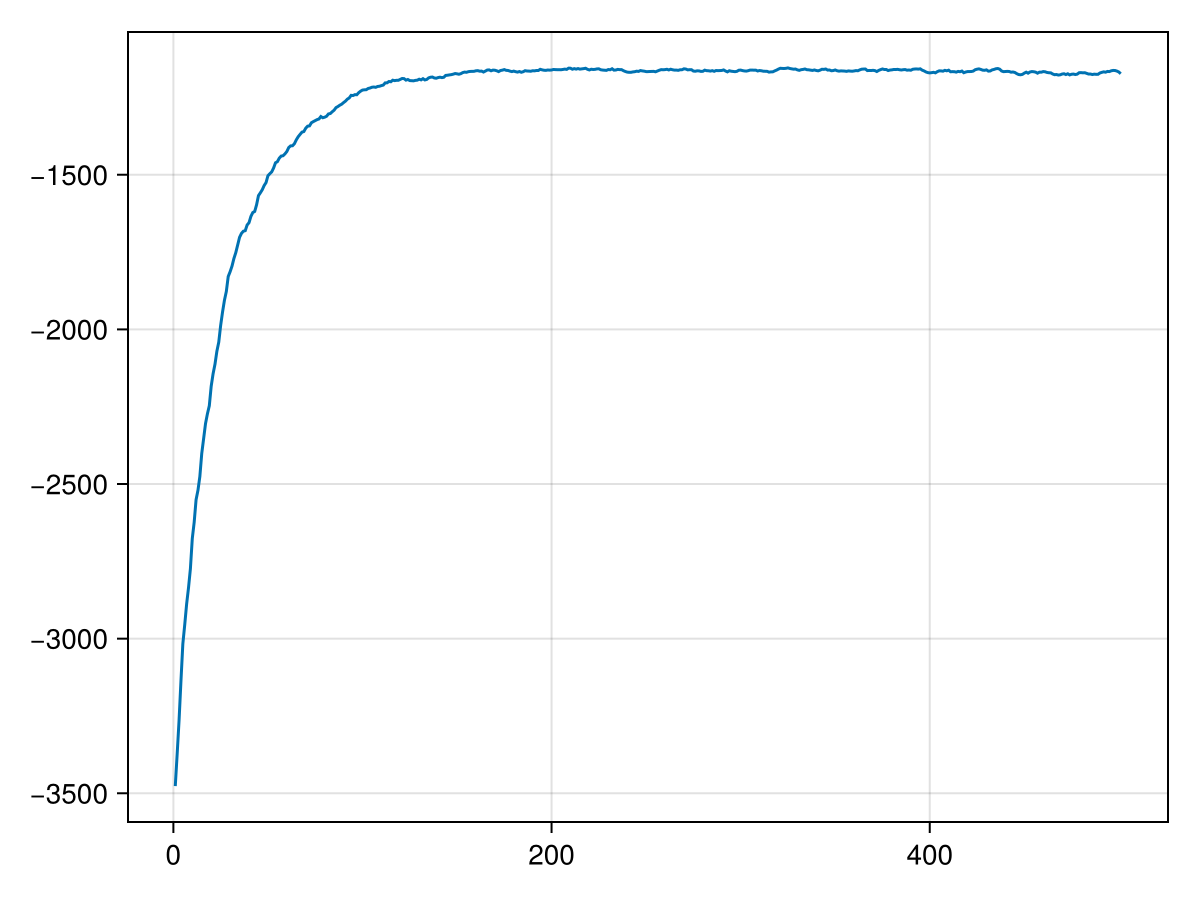

In [11]:
lines(scores)

In [12]:
policy, V = optimize(params[end], softmax_functions) 
pol = to_gym_pol(policy);
mean_rew = sepsis_gym.evaluate_policy(pol, 50000)

-0.2813

In [ ]:
nr_episodes = 10000

In [2]:
mutable struct History
    choices  # Equivalent to choicemap()
    policies::Vector{Policy}
    start_states::Vector{State}
    index::Int
    params::Dict
    scores::Dict
    acceptance::Dict
    sampled_params::Dict
    mean_rewards::Dict

    function History()
        return new(choicemap(), [], [], 0, Dict(), Dict(), Dict(), Dict(), Dict())
    end
end;


In [3]:
function add_episodes!(history::History, nr::Int)
    start = history.index
    for i in start+1:start+nr
        policy = sepsis_gym.random_policy()
        episode = sepsis_gym.run_episode(policy)

        push!(history.policies, to_policy(policy))
        push!(history.start_states, to_state(episode.visited[1]))
        
        history.choices = update_choicemap(history.choices, i, episode)
        history.index = i
    end
end

function train_history!(history::History, nr_iter::Int, functions)
    trace, _ = generate(sepsis_model, (history.policies, history.start_states, functions), history.choices)
    
    params = [functions.extract_parameters(trace)]
    scores = [get_score(trace)]
    acceptance = 0.0

    for _ in 1:nr_iter
        trace, a = drift_update(trace, 0.01)

        push!(params, functions.extract_parameters(trace))
        push!(scores, get_score(trace))
        acceptance += a
    end
    acceptance /= nr_iter

    history.params[history.index] = params
    history.scores[history.index] = scores
    history.acceptance[history.index] = acceptance

    posterior = params[end-100:end]
    
    mean_rew = []
    sampled_params = []
    for i in 1:10
        param = rand(posterior)
        push!(sampled_params, param)
        policy, V = optimize(param, functions) 
        pol = to_gym_pol(policy)
        r = sepsis_gym.evaluate_policy(pol, 100000)
        push!(mean_rew, r)
    end

    history.sampled_params[history.index] = sampled_params
    history.mean_rewards[history.index] = mean_rew

    return params, scores, acceptance, mean_rew
end

function save_file(self::Any, name::String)
    # Implement saving to file, e.g., using Serialization
    open(name, "w") do io
        serialize(io, self)
    end
end

function load_history(name::String)::History
    # Implement loading from file, e.g., using Serialization
    open(name, "r") do io
        return deserialize(io)
    end
end

load_history (generic function with 1 method)

In [4]:
history = History()
# first ten are detailed
for ep in 1:10
    add_episodes!(history, 1)
    train_history!(history, 200, softmax_functions)
    save_file(history, "data/mcmc/history-detailed-2.jld")
    println("$(ep) episodes done")
end
# from 10 on, always add 10 episodes until 150
for ep in 2:15
    add_episodes!(history, 10)
    train_history!(history, 200, softmax_functions)
    save_file(history, "data/mcmc/history-detailed-2.jld")
    println("$(ep * 10) episodes done")
end

1 episodes done
2 episodes done
3 episodes done


InterruptException: InterruptException: